In [1]:
from datagen import *
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import json
from IPython.display import HTML
import torch
from kwisatzHaderach import *
from Simple_model import *


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def animate3d(scene):
    scene = json.loads(scene)
    mass_save = np.array(scene['masses'])
    type_save = scene['types']
    bh_num = np.sum(np.array([1 if t == 'black hole' else 0 for t in type_save]))
    pos_save = np.array([f['pos'] for f in scene['frames']])

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    
    
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')


    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # set background color to black
    ax.set_facecolor('black')

    # set panel color to black
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False






    # get index of 2 biggest masses
    bh_index = np.argsort(mass_save)[::-1][:bh_num]

    masses_without_bh = np.delete(mass_save, bh_index)

    max_mass = np.max(masses_without_bh)
    min_mass = np.min(masses_without_bh)

    
    # Create the colormap (inferno)
    cmap = plt.cm.autumn
    colors = np.zeros((pos_save.shape[1], 4))


    for i in range(pos_save.shape[1]):
        if i in bh_index:
            colors[i] = [0, 0, 0, 1]
        else:
            colors[i] = cmap((mass_save[i] - min_mass) / (max_mass - min_mass))
    
    # shape of pos_save is (num_frames, num_particles, 3)
    scat = ax.scatter(pos_save[0, :, 0], pos_save[0, :, 1], pos_save[0, :, 2], c=colors)

    if mass_save is not None:
        masses = mass_save[:pos_save.shape[0]]
        masses = 10000 * np.sqrt(masses)
        masses[bh_index] = 10
        
        scat.set_sizes(masses)

    def update(i):
        # Update the positions of the particles
        scat._offsets3d = (pos_save[i, :, 0], pos_save[i, :, 1], pos_save[i, :, 2])




    ani = animation.FuncAnimation(fig, update, frames=pos_save.shape[0], interval=10)
    plt.close(fig)
    return HTML(ani.to_html5_video())



In [5]:
scene = generate_scene_2gals()

In [6]:
len(scene['masses'])

502

In [7]:
def get_pos_vel_mass_types_bh_index(scene):
    mass_save = np.array(scene['masses'])
    type_save = np.array(scene['types'])
    bh_index = np.where(type_save == 'black hole')[0]
    pos_save = np.array([f['pos'] for f in scene['frames']])
    vel_save = np.array([f['vel'] for f in scene['frames']])
    bh_pos = pos_save[:, bh_index]
    bh_vel = vel_save[:, bh_index]
    bh_mass = mass_save[bh_index]   
    return pos_save, vel_save, mass_save, type_save, bh_pos, bh_vel, bh_mass, bh_index

In [8]:
def get_new_pos_vel(acc, pos, vel, dt=0.01):
    new_vel = vel + acc * dt
    new_pos = pos + new_vel * dt
    return new_pos, new_vel

In [27]:
def model_create_sim(model, initial_positions, initial_velocities, masses, types, num_steps, device):
    model.eval()
    final_json = {
        'masses': masses.tolist(),
        'types': types,
        'frames': []
    }
    frames = []
    model = model.to(device)
    mass_tensor = torch.tensor(masses, dtype=torch.float32).unsqueeze(1).to(device)
    pos = torch.tensor(initial_positions, dtype=torch.float32).to(device)
    vel = torch.tensor(initial_velocities, dtype=torch.float32).to(device)

    
    print(mass_tensor.shape, pos.shape, vel.shape)
    frames.append({
        'frame': 0,
        'pos': initial_positions.tolist(),
        'vel': initial_velocities.tolist()
    })

    with torch.no_grad():
        for i in range(1, num_steps):
            acc = model(mass_tensor, pos)
            pos_pred, vel_pred = get_new_pos_vel(acc, pos, vel)
            frames.append({
                'frame': int(i),
                'pos': [[float(num) for num in pos_i] for pos_i in pos_pred.cpu().detach().numpy().tolist()],
                'vel': [[float(num) for num in vel_i] for vel_i in vel_pred.cpu().detach().numpy().tolist()]
            })
            pos = pos_pred
            vel = vel_pred
    final_json['frames'] = frames
    
    return final_json

def sim_accelerations(positions, masses, G=1):
        x = positions[:, 0:1]
        y = positions[:, 1:2]
        z = positions[:, 2:3]
        
        dx = x.T - x
        dy = y.T - y
        dz = z.T - z

        inv_r3 = (dx**2 + dy**2 + dz**2)
        inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0]**(-1.5)
        
        ax = G * (dx * inv_r3) @ masses
        ay = G * (dy * inv_r3) @ masses
        az = G * (dz * inv_r3) @ masses

        return np.hstack((ax, ay, az))

def model_simulator_mixed(interval, model, initial_positions, initial_velocities, masses, types, num_steps, device):
    model.eval()
    final_json = {
        'masses': masses.tolist(),
        'types': types,
        'frames': []
    }
    frames = []
    model = model.to(device)
    mass_tensor = torch.tensor(masses, dtype=torch.float32).unsqueeze(1).to(device)
    pos = torch.tensor(initial_positions, dtype=torch.float32).to(device)
    vel = torch.tensor(initial_velocities, dtype=torch.float32).to(device)

    
    frames.append({
        'frame': 0,
        'pos': initial_positions.tolist(),
        'vel': initial_velocities.tolist()
    })

    with torch.no_grad():
        for i in range(1, num_steps):
            if i % interval == 0:
                acc = sim_accelerations(pos, masses)
            else:
                acc = model(mass_tensor, pos)
            pos_pred, vel_pred = get_new_pos_vel(acc, pos, vel)
            frames.append({
                'frame': int(i),
                'pos': [[float(num) for num in pos_i] for pos_i in pos_pred.cpu().detach().numpy().tolist()],
                'vel': [[float(num) for num in vel_i] for vel_i in vel_pred.cpu().detach().numpy().tolist()]
            })
            pos = pos_pred
            vel = vel_pred

    final_json['frames'] = frames
    
    return final_json


    
def model_create_sim_bh(model, initial_positions, initial_velocities, masses, types, num_steps, device, bh_index):
    model.eval()
    final_json = {
        'masses': masses.tolist(),
        'types': types,
        'frames': []
    }
    frames = []
    bh_index = torch.tensor(bh_index, dtype=torch.long).to(device)
    model = model.to(device)
    mass_tensor = torch.tensor(masses, dtype=torch.float32).unsqueeze(1).to(device)
    pos = torch.tensor(initial_positions, dtype=torch.float32).to(device)
    vel = torch.tensor(initial_velocities, dtype=torch.float32).to(device)
    pos_bh = pos[bh_index].to(device)
    vel_bh = vel[bh_index].to(device)
    mass_bh = mass_tensor[bh_index].to(device)
    
    frames.append({
        'frame': 0,
        'pos': initial_positions.tolist(),
        'vel': initial_velocities.tolist()
    })

    with torch.no_grad():
        for i in range(1, num_steps):
            acc = model(pos, vel, mass_tensor, pos_bh, vel_bh, mass_bh)
            pos_pred, vel_pred = get_new_pos_vel(acc, pos, vel)
            frames.append({
                'frame': int(i),
                'pos': [[float(num) for num in pos_i] for pos_i in pos_pred.cpu().detach().numpy().tolist()],
                'vel': [[float(num) for num in vel_i] for vel_i in vel_pred.cpu().detach().numpy().tolist()]
            })
            pos = pos_pred
            vel = vel_pred
            pos_bh = pos[bh_index]
            vel_bh = vel[bh_index]
    final_json['frames'] = frames
    
    return json.dumps(final_json)

    

In [28]:
import os
model = ContinuousConvolutionModel(kernel_size=[7,7,7], num_features = 1)
model_weights_list = os.listdir('./models/')
model_weights_list.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
last_model = model_weights_list[-1]
print(last_model)
model.load_state_dict(torch.load(f'./models/{last_model}')) #  map_location=torch.device('cpu')


model_2.pt


<All keys matched successfully>

In [29]:
pos, vel, mass, types, _, _, _, _ = get_pos_vel_mass_types_bh_index(scene)
intitial_positions = pos[20]
initial_velocities = vel[20]
print(intitial_positions.shape, initial_velocities.shape, mass.shape)
predicted_scene = model_simulator_mixed(10, model, intitial_positions, initial_velocities, mass, types, 1001, 'cuda')

(502, 3) (502, 3) (502,)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [20]:
masses = np.array(predicted_scene['masses'])
gt_pos = np.array([f['pos'] for f in scene['frames']])[20:]
pred_pos = np.array([f['pos'] for f in predicted_scene['frames']])[:-20]
types = np.array(predicted_scene['types'])

In [21]:
gt_pos.shape, pred_pos.shape, masses.shape, types.shape

((981, 502, 3), (981, 502, 3), (502,), (502,))

In [22]:
def euclidean_distance(a, b, epsilon=1e-9):
    return torch.sqrt(torch.sum((a - b)**2, dim=-1) + epsilon)

def euclidean_distance_linalg(a, b):
    return np.linalg.norm(a - b, axis=-1)

In [23]:
np.mean(euclidean_distance_linalg(gt_pos, pred_pos), axis=-1)

array([0.00000000e+00, 1.52259515e-04, 4.27760699e-04, 8.67384382e-04,
       1.47295488e-03, 2.24222145e-03, 3.17382651e-03, 4.26578506e-03,
       5.51593799e-03, 6.92248654e-03, 8.48350153e-03, 1.01972641e-02,
       1.20613056e-02, 1.40733483e-02, 1.62313817e-02, 1.85322691e-02,
       2.09741781e-02, 2.35556771e-02, 2.62750281e-02, 2.91313651e-02,
       3.21249682e-02, 3.52565937e-02, 3.85269666e-02, 4.19366825e-02,
       4.54861447e-02, 4.91765657e-02, 5.30094913e-02, 5.69858937e-02,
       6.11061125e-02, 6.53710021e-02, 6.97808775e-02, 7.43357272e-02,
       7.90359000e-02, 8.38812132e-02, 8.88715580e-02, 9.40063921e-02,
       9.92855718e-02, 1.04709010e-01, 1.10275435e-01, 1.15984246e-01,
       1.21835063e-01, 1.27827617e-01, 1.33961387e-01, 1.40235006e-01,
       1.46646812e-01, 1.53194696e-01, 1.59876599e-01, 1.66689980e-01,
       1.73632698e-01, 1.80702275e-01, 1.87896073e-01, 1.95212424e-01,
       2.02650175e-01, 2.10208063e-01, 2.17885315e-01, 2.25680935e-01,
      

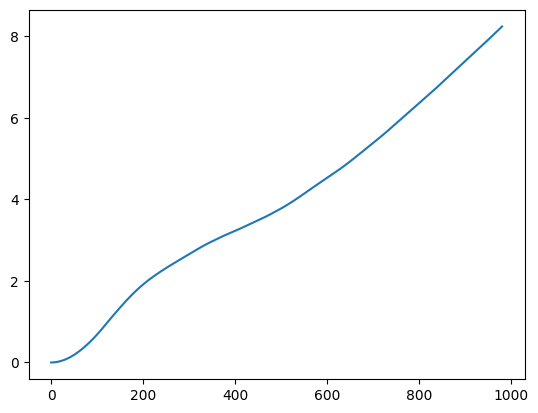

In [26]:
# plot the distance between the predicted and ground truth positions
plt.plot(np.mean(euclidean_distance_linalg(gt_pos, pred_pos), axis=-1))

In [24]:
def animate_ground_truth_vs_prediction(masses, types, gt_pos, pred_pos):
    # create a 2 animation side by side, do in 3d    
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(-2, 2)
    ax1.set_zlim(-2, 2)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.set_title('Ground Truth')


    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.set_zlim(-2, 2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_title('Prediction')

    # get index of 2 black holes
    types = np.array(types)
    bh_index = np.where(types == 'black hole')[0]

    masses_without_bh = np.delete(masses, bh_index)

    max_mass = np.max(masses_without_bh)
    min_mass = np.min(masses_without_bh)

    # Create the colormap (inferno)
    cmap = plt.cm.autumn
    colors = np.zeros((gt_pos.shape[1], 4))

    for i in range(gt_pos.shape[1]):
        if i in bh_index:
            colors[i] = [0, 0, 0, 1]
        else:
            colors[i] = cmap((masses[i] - min_mass) / (max_mass - min_mass))

    # shape of pos_save is (num_frames, num_particles, 3)
    scat1 = ax1.scatter(gt_pos[0, :, 0], gt_pos[0, :, 1], gt_pos[0, :, 2], c=colors)

    if masses is not None:
        masses = masses[:gt_pos.shape[0]]
        masses = 100 * np.sqrt(masses)
        masses[bh_index] = 10
        scat1.set_sizes(masses)

    scat2 = ax2.scatter(pred_pos[0, :, 0], pred_pos[0, :, 1], pred_pos[0, :, 2], c=colors)

    if masses is not None:
        scat2.set_sizes(masses)

    error_per_frame = np.linalg.norm(gt_pos - pred_pos, axis=-1)

    

    def update(i):
        # Update the positions of the particles
        scat1._offsets3d = (gt_pos[i, :, 0], gt_pos[i, :, 1], gt_pos[i, :, 2])
        scat2._offsets3d = (pred_pos[i, :, 0], pred_pos[i, :, 1], pred_pos[i, :, 2])


    ani = animation.FuncAnimation(fig, update, frames=gt_pos.shape[0], interval=10)
    plt.close(fig)
    return HTML(ani.to_html5_video())

In [25]:
animate_ground_truth_vs_prediction(masses, types, gt_pos, pred_pos)